# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [128]:
!pip -q install ./python

In [1]:
from unityagents import UnityEnvironment
import numpy as np

import time
import random
import torch
import numpy as np
from itertools import count
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from ddpg_agent import Agent

%load_ext autoreload
%autoreload 2

In [2]:
env = UnityEnvironment(file_name='../../Reacher_Linux/Reacher')
# env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

env_info = env.reset(train_mode=True)[brain_name]
num_agents = len(env_info.agents)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
state_size, action_size = brain.vector_observation_space_size, brain.vector_action_space_size
agent = Agent(state_size=state_size, action_size=action_size, random_seed=2)

Episode 1, Mean last 100: 0.01, Mean current: 0.01, Max: 0.13, Min: 0.00, Time: 12.50
Episode 2, Mean last 100: 0.04, Mean current: 0.07, Max: 0.64, Min: 0.00, Time: 12.67
Episode 3, Mean last 100: 0.33, Mean current: 0.91, Max: 1.70, Min: 0.42, Time: 13.00
Episode 4, Mean last 100: 0.38, Mean current: 0.54, Max: 1.20, Min: 0.08, Time: 13.24
Episode 5, Mean last 100: 0.50, Mean current: 0.99, Max: 1.72, Min: 0.05, Time: 13.54
Episode 6, Mean last 100: 0.60, Mean current: 1.06, Max: 2.57, Min: 0.08, Time: 14.14
Episode 7, Mean last 100: 0.70, Mean current: 1.32, Max: 2.15, Min: 0.12, Time: 14.41
Episode 8, Mean last 100: 0.67, Mean current: 0.45, Max: 1.01, Min: 0.00, Time: 14.66
Episode 9, Mean last 100: 0.63, Mean current: 0.32, Max: 1.04, Min: 0.00, Time: 15.17
Episode 10, Mean last 100: 0.61, Mean current: 0.48, Max: 1.47, Min: 0.00, Time: 15.96
Episode 11, Mean last 100: 0.64, Mean current: 0.88, Max: 2.40, Min: 0.04, Time: 16.62
Episode 12, Mean last 100: 0.66, Mean current: 0.86,

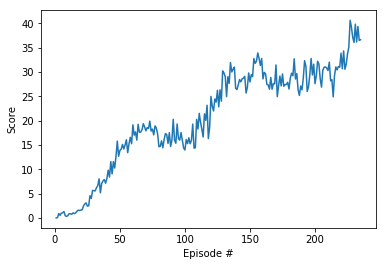

In [174]:
def ddpg(n_episodes=300, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores_global = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        
        agent.reset()
        tick = time.time()
        for i_step in count():
            actions = agent.act(states)
            # return
            
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            scores += env_info.rewards                         # update the score (for each agent)
            
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done)
            
            if i_step % print_every == 0:
                print('\rStep {}\tAverage Score: {:.2f}'.format(i_step, np.mean(scores)), end="")
            
            if np.any(dones):                                  # exit loop if episode finished
                break
            
            states = next_states                               # roll over states to next time step
        
        agent.sampleandlearn()
        
        score = np.mean(scores)
        scores_deque.append(score)
        scores_global.append(score)
        print('\rEpisode {}, Mean last 100: {:.2f}, Mean current: {:.2f}, Max: {:.2f}, Min: {:.2f}, Len: {}, Time: {:.2f}'\
              .format(i_episode, np.mean(scores_deque), score, np.max(scores), np.min(scores), len(agent.memory)
                      , time.time()-tick), end="\n")
        if i_episode % 10 == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            
    return scores_global

scores = ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [4]:
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

In [5]:
for i_episode in range(2):
    env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    agent.reset()
    for i_step in count():
        actions = agent.act(states)
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations
        states = next_states
        if np.any(env_info.local_done):                                  # exit loop if episode finished
                break